# Data Mining Midterm Project
### Why We Chose This Dataset:
This data set is extremely robust with information that is thought to be linked to health. There are extensive subsets such as demographics, diet, exams, labs, and more that can be analyzed to find correlations that contribute positively or negatively to overall health. There are a lot of questions that can be answered with this data set; we will try to focus on a few we think are interesting to us
### Business Questions:
1. Can we identify people at risk of a specific disease?
- Can we identify people at risk of diabetes?
### Project Outline:
1. **Software Engineering** - Will build functions such as to streamline data transformations and visualizations within the dataframe(s).
2. **Data Engineering** - Will clean, organize, and transform the data for ease of use during the research and analysis portion of the project. Featurization. 
3. **Business Analysis** - Discover initial challenge questions for the dataset(s). Then evolve the questions as we iterate through the project. 
4. **Research** - After featurization, extract metadata on the full dataset and run clustering/dimentions reduction on various slices of the data. Metadata will be added to each cluster. Each iteration may vary on addition/deletion of features as we attempts to gain a conclusion on our business questions. 
### Resources:
- https://www.kaggle.com/datasets/cdc/national-health-and-nutrition-examination-survey

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings("ignore")

In [3]:
demo = pd.read_csv('nhnes/demographic.csv')
diet = pd.read_csv('nhnes/diet.csv')
exam = pd.read_csv('nhnes/examination.csv')
labs = pd.read_csv('nhnes/labs.csv')
ques = pd.read_csv('nhnes/questionnaire.csv')

**Useful Functions**

In [4]:
# Drops columns and rows based on null percentage. Remaining null cells are replaced with the mode of the column
def null_handler(df):
    orig_col = df.shape[1]
    orig_row = df.shape[0]

    col_perc = 50.0
    row_perc = 75.0

    min_col =  int(((100-col_perc)/100)*df.shape[0] + 1)
    df = df.dropna( axis=1, thresh=min_col)
    print("Dropped {} columns with over 50% null values.".format(orig_col - df.shape[1]))

    min_row =  int(((100-row_perc)/100)*df.shape[1] + 1)
    df = df.dropna( axis=0, thresh=min_row)
    print("Dropped {} rows with over 75% null values.".format(orig_row - df.shape[0]))
    
    for i in df.columns:
        df[i] = df[i].fillna(df[i].mode()[0])
    print("Replaced remaining null values with mode of column.")
    return df

# Returns a dataframe showing the percentage of null values in each column
def get_nulls(df):
    sum_null = df.isnull().sum()
    df_shape = df.shape[0]
    null = 100 * (sum_null / df_shape)
    return pd.DataFrame({'nullPercent': null})

# Creates a correlation matrix based on data passed as an argument. 
def corr_matrix(df, title):
    cmap = sns.color_palette("plasma", as_cmap=True)
    fig = plt.figure(figsize=(10, 8))
    map = sns.heatmap(df.corr(), cmap=cmap)
    plt.title(title,fontsize=15)
    labels=df.columns
    plt.show()

# fits and scales a dataframe in preparation for PCA using StandardScaler()
def fit_and_scale(df):
    ss = StandardScaler()
    X = ss.fit_transform(df)
    return pd.DataFrame(data=X, columns=df.columns[0:])

# Creates a bar graph explaining variance of principal components. 
def expl_var_bargraph(dfx, n, title):
    pca = PCA(n_components=n)
    dfx_pca = pca.fit(dfx)
    length = len(dfx_pca.explained_variance_ratio_)

    x_vals = [i for i in range(length)]
    y_vals = pca.explained_variance_ratio_
    x_ticks = [i for i in range(0, length, 20)]

    plt.figure(figsize=(10,6))
    sns.barplot(x=x_vals,y=y_vals, palette='plasma')
    plt.title("{}:Variance of Components".format(title), fontsize=18)
    plt.xlabel("Principal components",fontsize=15)
    plt.ylabel("Explained variance ratio",fontsize=15)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
  
    plt.show()

# Creates a scatter plot based on pca and n components
def pca_scatter(dfx, n, c):
    pca = PCA(n_components=n)
    dfx_trans = pca.fit_transform(dfx)
    dfx_trans = pd.DataFrame(data=dfx_trans)
    dfx_trans.head(10)

    plt.figure(figsize=(10,6))
    cmap = sns.color_palette("plasma", as_cmap=True)
    plt.scatter(dfx_trans[0], dfx_trans[1], c=c,edgecolors='k',alpha=0.75,s=150, cmap=cmap)
    plt.xlabel("Principal component-1",fontsize=15)
    plt.ylabel("Principal component-2",fontsize=15)
    plt.show()



### Data Cleaning: 

1. Rename columns
2. Merge all datasets into one dataframe
3. Handle null values in the dataframe

In [5]:
col_decoder = {
'ALQ101' : 'drink_alcohol',
'BMDAVSAD' : 'saggital_abdominal_avg',
'BMXARMC' : 'arm_circum',
'BMXBMI' : 'BMI',
'BMXLEG' : 'leg_length',
'BMXSAD1' : 'saggital_abdominal_1',
'BMXSAD2' : 'saggital_abdominal_2',
'BMXWAIST' : 'waist_circum',
'BMXWT' : 'weight_kg',
'BPQ020' : 'high_bp',
'BPQ080' : 'high_cholesterol',
'BPXDI1' : 'diastolic_bp',
'CBQ505' : 'fast_food',
'DBQ229' : 'milk_drinker',
'DBQ700' : 'healthy_diet',
'DIQ010' : 'diabetes',
'DIQ050' : 'taking_insulin',
'DIQ160' : 'prediabetes',
'DIQ170' : 'diabetes_risk',
'DIQ172' : 'diabetes_concern',
'DR1.320Z' : 'water',
'DR1TACAR' : 'dietary_alpha_carotene',
'DR1TALCO' : 'alcohol',
'DR1TATOC' : 'dietary_vitamin_e',
'DR1TBCAR' : 'dietary_beta_carotene',
'DR1TCAFF' : 'caffeine',
'DR1TCALC' : 'dietary_calcium',
'DR1TCARB' : 'carb',
'DR1TCHL' : 'dietary_choline',
'DR1TCHOL' : 'cholesterol',
'DR1TCOPP' : 'dietary_copper',
'DR1TCRYP' : 'dietary_beta_cryptoxanthin',
'DR1TFA' : 'dietary_folic_acid',
'DR1TFF' : 'folate_food',
'DR1TFIBE' : 'fiber',
'DR1TFOLA' : 'dietary_folate',
'DR1TIRON' : 'dietary_iron',
'DR1TKCAL' : 'calories',
'DR1TLYCO' : 'dietary_lycopene',
'DR1TLZ' : 'dietary_lutein',
'DR1TM181' : 'octadecenoic_percent',
'DR1TMAGN' : 'magnesium',
'DR1TMFAT' : 'monounsaturated_fats',
'DR1TMOIS' : 'moisture',
'DR1TNIAC' : 'dietary_niacin',
'DR1TP183' : 'octadecatrienoic_percent',
'DR1TPHOS' : 'dietary_phosphorus',
'DR1TPOTA' : 'dietary_potassium',
'DR1TPROT' : 'protein',
'DR1TRET' : 'dietary_retinol',
'DR1TS140' : 'tetradeconoic_percent',
'DR1TSELE' : 'dietary_selenium',
'DR1TSODI' : 'sodium',
'DR1TSUGR' : 'sugar',
'DR1TTFAT' : 'fat',
'DR1TTHEO' : 'dietary_theobromine',
'DR1TVARA' : 'dietary_vitamin_a',
'DR1TVB1' : 'dietary_b1',
'DR1TVB12' : 'dietary_b12',
'DR1TVB2' : 'dietary_b2',
'DR1TVB6' : 'dietary_b6',
'DR1TVC' : 'dietary_vit_c',
'DR1TVD' : 'dietary_vit_d',
'DR1TVK' : 'dietary_vit_k',
'DR1TZINC' : 'dietary_zinc',
'DRABF' : 'breast_fed',
'DRQSPREP' : 'salt_used',
'DUQ200' : 'marijuana',
'HEQ010' : 'hepetitis_b',
'HEQ030' : 'hepetitis_c',
'HSD010' : 'general_health',
'HSQ500' : 'ever_had_cold',
'HSQ510' : 'intestinal_illness',
'HSQ520' : 'ever_had_flu',
'HSQ571' : 'donate_blood',
'HSQ590' : 'hiv',
'IMQ011' : 'hepatitis_a_vaccine',
'IMQ020' : 'hepatitis_b_vaccine',
'IND235' : 'monthly_income',
'INDFMPIR' : 'family_income',
'LBDBCDLC' : 'blood_cadmium',
'LBDBGMLC' : 'methyl_mercury',
'LBDHDD' : 'HDL_mg',
'LBDIHGLC' : 'inorganic_mercury',
'LBDNENO' : 'neutrophils_percent',
'LBDTHGLC' : 'blood_mercury',
'LBDWFL' : 'floride_water',
'LBXEOPCT' : 'eosinophils_percent',
'LBXGH' : 'glyco_hemoglobin',
'LBXLYPCT' : 'lymphocite_percent',
'LBXMC' : 'hemoglobin_concentration',
'LBXSAL' : 'blood_albumin',
'LBXSCA' : 'blood_calcium',
'LBXSGL' : 'serum_glucose_mg',
'LBXSTP' : 'blood_protein',
'MCQ010' : 'asthma_ever',
'MCQ025' : 'asthma_age',
'MCQ035' : 'asthma',
'MCQ040' : 'asthma_year',
'MCQ050' : 'asthma_ER',
'MCQ053' : 'anemia',
'MCQ070' : 'psoriasis',
'MCQ080' : 'overweight',
'MCQ082' : 'celiac_disease',
'MCQ086' : 'gluten_free',
'MCQ092' : 'blood_transfusion',
'MCQ149' : 'menstruate',
'MCQ151' : 'menstruate_age',
'MCQ160A' : 'arthritis',
'MCQ160B' : 'congestive_heart_failure',
'MCQ160C' : 'coronary_heart_disease',
'MCQ160D' : 'angina',
'MCQ160E' : 'heart_attack',
'MCQ160F' : 'stroke',
'MCQ160G' : 'emphysema',
'MCQ160K' : 'bronchitis_ever',
'MCQ160L' : 'liver_condition_ever',
'MCQ160M' : 'thyroid_ever',
'MCQ160N' : 'gout',
'MCQ160O' : 'COPD',
'MCQ170L' : 'liver_condition',
'MCQ195' : 'arthritis_type',
'MCQ203' : 'jaundice',
'MCQ220' : 'cancer',
'MCQ300A' : 'relative_heart_attack',
'MCQ300B' : 'relative_asthma',
'MCQ300C' : 'relative_diabetes',
'MCQ365A' : 'need_weight_loss',
'MCQ365B' : 'need_exercise',
'MCQ365C' : 'need_reduce_salt',
'MCQ365D' : 'need_reduce_calories',
'MCQ370A' : 'losing_weight',
'MCQ370B' : 'excercising',
'MCQ370C' : 'reducing_salt',
'MCQ370D' : 'reducing_fat',
'MGDCGSZ' : 'grip_strength',
'OSQ130' : 'take_prednisone',
'PAD680' : 'sedentary_time',
'PAQ605' : 'vigorous_work',
'PAQ620' : 'moderate_work',
'PAQ635' : 'walk_or_bike',
'PAQ650' : 'vigorous_recreation',
'PAQ665' : 'moderate_recreation',
'PAQ710' : 'tv_hours',
'PAQ715' : 'pc_hours',
'PFQ054' : 'walk_equipment_required',
'PFQ057' : 'confusion_memory_problems',
'PFQ090' : 'special_healthcare_equipment',
'RIAGENDR' : 'gender',
'SEQN' : 'id',
'DMDYRSUS' : 'us_citizen',
'INDFMPIR' : 'family_income',
'RIDAGEYR' : 'age',
'RIDRETH1' : 'hispanic',
'RXQ510' : 'take_aspirin',
'SLD010H' : 'sleep_hours',
'SLQ050' : 'trouble_sleeping',
'SLQ060' : 'sleep_disorder',
'SMD460' : 'smokers_in_house',
'SMDANY' : 'tobaco_1w',
'SMQ681' : 'smoked_1w',
'SMQ863' : 'nicotine_1w',
'SXD021' : 'sex_ever',
'URXUCR' : 'creatinine_urine',
'WHD010' : 'height_in',
'WHD020' : 'current_weight_lb',
'WHD140' : 'greatest_weight',
'WHQ040' : 'weightloss_desire',
'WHQ070' : 'weightloss_attempt',
'WHQ150' : 'age_when_heaviest'
}

keep_cols = list(col_decoder.values())
labs = labs.rename(columns = col_decoder)
exam = exam.rename(columns = col_decoder)
demo = demo.rename(columns = col_decoder)
diet = diet.rename(columns = col_decoder)
ques = ques.rename(columns = col_decoder)

labs = labs[labs.columns.intersection(keep_cols)]
exam = exam[exam.columns.intersection(keep_cols)]
demo = demo[demo.columns.intersection(keep_cols)]
diet = diet[diet.columns.intersection(keep_cols)]
ques = ques[ques.columns.intersection(keep_cols)]

# df = df.rename(columns = col_decoder)
# df = df[df.columns.intersection(keep_cols)]
# df.head()

In [6]:
labs = null_handler(labs)
exam = null_handler(exam)
demo = null_handler(demo)
diet = null_handler(diet)
ques = null_handler(ques)

Dropped 2 columns with over 50% null values.
Dropped 1260 rows with over 75% null values.
Replaced remaining null values with mode of column.
Dropped 0 columns with over 50% null values.
Dropped 142 rows with over 75% null values.
Replaced remaining null values with mode of column.
Dropped 1 columns with over 50% null values.
Dropped 0 rows with over 75% null values.
Replaced remaining null values with mode of column.
Dropped 0 columns with over 50% null values.
Dropped 1282 rows with over 75% null values.
Replaced remaining null values with mode of column.
Dropped 12 columns with over 50% null values.
Dropped 1965 rows with over 75% null values.
Replaced remaining null values with mode of column.


In [7]:
df = pd.concat([labs, exam, demo, diet, ques], axis=1)
df = df.loc[:,~df.columns.duplicated()]
df

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
0,73557.0,4.1,9.5,554.0,6.5,42.2,3.4,2.0,33.4,65.0,...,1.0,1.0,2.0,1.0,69.0,180.0,3.0,2.0,270.0,62.0
1,73558.0,4.7,9.2,219.0,7.8,27.3,6.1,7.4,32.5,50.0,...,2.0,1.0,2.0,1.0,71.0,200.0,3.0,2.0,250.0,25.0
2,73559.0,3.7,8.9,183.0,5.9,13.9,5.6,4.9,34.3,60.0,...,0.0,2.0,2.0,2.0,70.0,195.0,2.0,2.0,228.0,35.0
3,73560.0,4.4,9.4,92.0,7.1,29.6,1.7,4.6,34.0,61.0,...,1.0,2.0,2.0,2.0,66.0,160.0,2.0,2.0,180.0,40.0
4,73561.0,4.3,10.0,104.0,7.1,20.5,2.4,4.5,33.0,85.0,...,0.0,2.0,2.0,2.0,67.0,120.0,1.0,2.0,170.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,2.0,2.0,69.0,150.0,3.0,2.0,150.0,26.0
10171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,2.0,2.0,64.0,195.0,2.0,1.0,195.0,42.0
10173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = null_handler(df)
df

Dropped 0 columns with over 50% null values.
Dropped 287 rows with over 75% null values.
Replaced remaining null values with mode of column.


,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
0,73557.0,4.1,9.5,554.0,6.5,42.2,3.4,2.0,33.4,65.0,...,1.0,1.0,2.0,1.0,69.0,180.0,3.0,2.0,270.0,62.0
1,73558.0,4.7,9.2,219.0,7.8,27.3,6.1,7.4,32.5,50.0,...,2.0,1.0,2.0,1.0,71.0,200.0,3.0,2.0,250.0,25.0
2,73559.0,3.7,8.9,183.0,5.9,13.9,5.6,4.9,34.3,60.0,...,0.0,2.0,2.0,2.0,70.0,195.0,2.0,2.0,228.0,35.0
3,73560.0,4.4,9.4,92.0,7.1,29.6,1.7,4.6,34.0,61.0,...,1.0,2.0,2.0,2.0,66.0,160.0,2.0,2.0,180.0,40.0
4,73561.0,4.3,10.0,104.0,7.1,20.5,2.4,4.5,33.0,85.0,...,0.0,2.0,2.0,2.0,67.0,120.0,1.0,2.0,170.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10167,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,0.0,2.0,2.0,2.0,70.0,173.0,3.0,2.0,190.0,55.0
10169,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,0.0,2.0,2.0,2.0,66.0,180.0,3.0,2.0,180.0,40.0
10170,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,0.0,2.0,2.0,2.0,69.0,150.0,3.0,2.0,150.0,26.0
10172,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,0.0,2.0,2.0,2.0,64.0,195.0,2.0,1.0,195.0,42.0


**Some simple EDA to try to understand the dataframe**

In [9]:
diab_df = df.groupby('diabetes').mean().sort_values(by=['diabetes'], ascending=True)
diab_df

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
diabetes,,,,,,,,,,,,,,,,,,,,,
1.0,77605.509511,4.322011,9.474321,98.527174,7.110190,33.156522,2.831929,4.033967,33.827174,51.543478,...,2.394022,1.843750,1.997283,1.824728,241.607337,272.302989,2.165761,1.710598,396.381793,593.650815
2.0,77929.404329,4.323842,9.456097,98.812897,7.104661,32.886511,2.782986,4.054022,33.809216,51.881178,...,0.684927,1.869240,1.997769,1.860538,121.389825,216.593217,2.155082,1.804864,252.802410,351.183309
3.0,77712.244565,4.302717,9.423913,95.701087,7.095652,32.607609,2.871739,4.034239,33.788587,52.967391,...,0.336957,1.847826,1.994565,1.836957,66.021739,193.038043,2.086957,1.619565,265.711957,49.994565
9.0,75988.400000,4.400000,9.460000,92.600000,7.080000,38.400000,1.080000,3.880000,33.520000,49.800000,...,0.400000,1.800000,1.800000,1.800000,64.400000,2125.800000,3.600000,1.400000,210.800000,44.400000


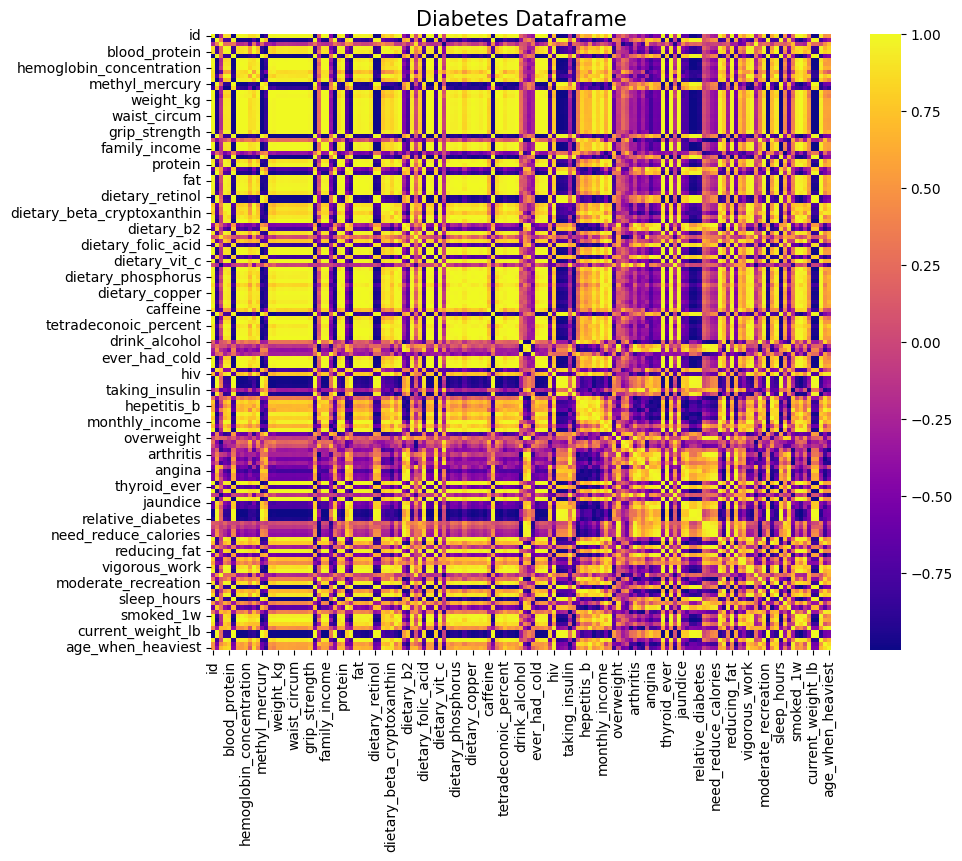

In [10]:
corr_matrix(diab_df, 'Diabetes Dataframe')

In [11]:
glyco_df = df.groupby('glyco_hemoglobin').mean().sort_values(by=['glyco_hemoglobin'], ascending=True)
glyco_df.head()

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
glyco_hemoglobin,,,,,,,,,,,,,,,,,,,,,
3.5,81009.0,3.1,9.200000,77.000000,6.100000,37.800000,0.600000,3.100000,32.300000,59.000000,...,0.0,2.000000,2.0,2.000000,64.0,205.000000,2.0,1.0,215.0,53.000000
3.7,77584.0,3.7,8.900000,79.000000,6.900000,28.800000,2.000000,4.200000,34.600000,40.000000,...,0.0,2.000000,2.0,2.000000,66.0,160.000000,2.0,2.0,180.0,40.000000
3.8,82420.0,4.4,9.100000,81.000000,6.800000,45.800000,1.200000,1.700000,34.000000,63.000000,...,0.0,2.000000,2.0,2.000000,64.0,170.000000,2.0,2.0,170.0,49.000000
3.9,78575.0,4.9,9.700000,88.000000,7.900000,30.400000,1.500000,3.700000,33.600000,48.000000,...,0.0,2.000000,2.0,2.000000,66.0,160.000000,2.0,2.0,180.0,40.000000
4.1,76590.0,4.1,9.166667,88.333333,7.066667,28.633333,5.966667,3.533333,33.366667,38.666667,...,0.0,1.666667,2.0,1.666667,67.0,167.666667,2.0,2.0,182.0,47.666667


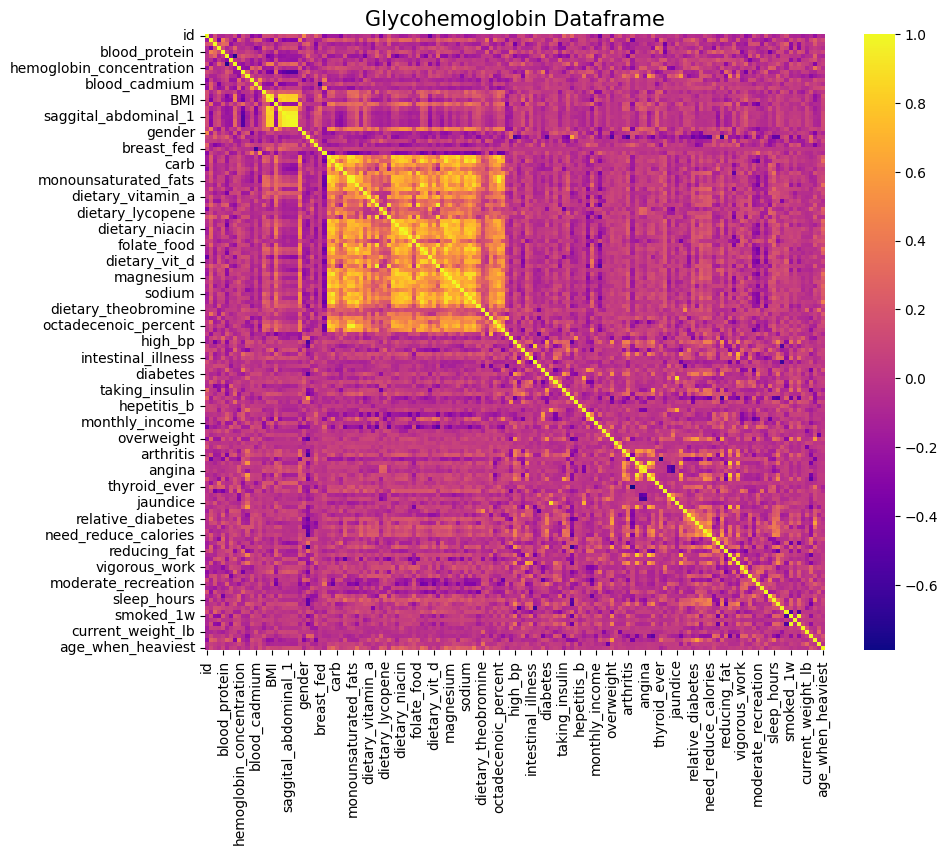

In [12]:
corr_matrix(glyco_df, 'Glycohemoglobin Dataframe')

In [13]:
bmi_df = df.groupby('BMI').mean().sort_values(by=['BMI'], ascending=True)
bmi_df

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
BMI,,,,,,,,,,,,,,,,,,,,,
12.1,73557.000000,4.4,9.4,92.0,7.1,28.800000,1.700000,3.800000,33.800000,48.000000,...,0.000000,2.000000,2.0,2.000000,67.000000,135.000000,2.000000,1.000000,180.000000,40.000000
12.3,82549.000000,4.4,9.4,92.0,7.1,39.400000,1.700000,4.700000,34.000000,54.000000,...,0.000000,2.000000,2.0,2.000000,69.000000,190.000000,2.000000,1.000000,180.000000,40.000000
12.6,77199.666667,4.4,9.4,92.0,7.1,40.466667,2.500000,3.900000,33.866667,61.000000,...,0.000000,2.000000,2.0,2.000000,67.666667,181.000000,2.333333,1.333333,187.666667,40.333333
12.7,77218.000000,4.4,9.4,92.0,7.1,47.600000,2.000000,2.800000,34.400000,48.000000,...,0.000000,2.000000,2.0,2.000000,66.000000,160.000000,2.000000,2.000000,180.000000,40.000000
12.9,77711.000000,4.4,9.4,92.0,7.1,38.100000,3.014286,3.685714,34.100000,46.428571,...,0.428571,1.857143,2.0,1.857143,66.714286,169.857143,2.000000,2.000000,185.428571,50.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.6,74910.000000,3.6,9.4,90.0,7.0,32.300000,0.900000,4.400000,32.400000,46.000000,...,0.000000,2.000000,2.0,2.000000,66.000000,160.000000,2.000000,2.000000,180.000000,40.000000
70.1,77239.000000,4.2,9.4,86.0,7.4,25.400000,2.300000,5.500000,33.200000,45.000000,...,0.000000,2.000000,2.0,2.000000,69.000000,170.000000,3.000000,2.000000,220.000000,62.000000
74.1,77077.000000,4.0,9.3,94.0,7.6,17.000000,0.600000,9.000000,35.000000,57.000000,...,1.000000,2.000000,2.0,2.000000,66.000000,160.000000,2.000000,2.000000,180.000000,40.000000


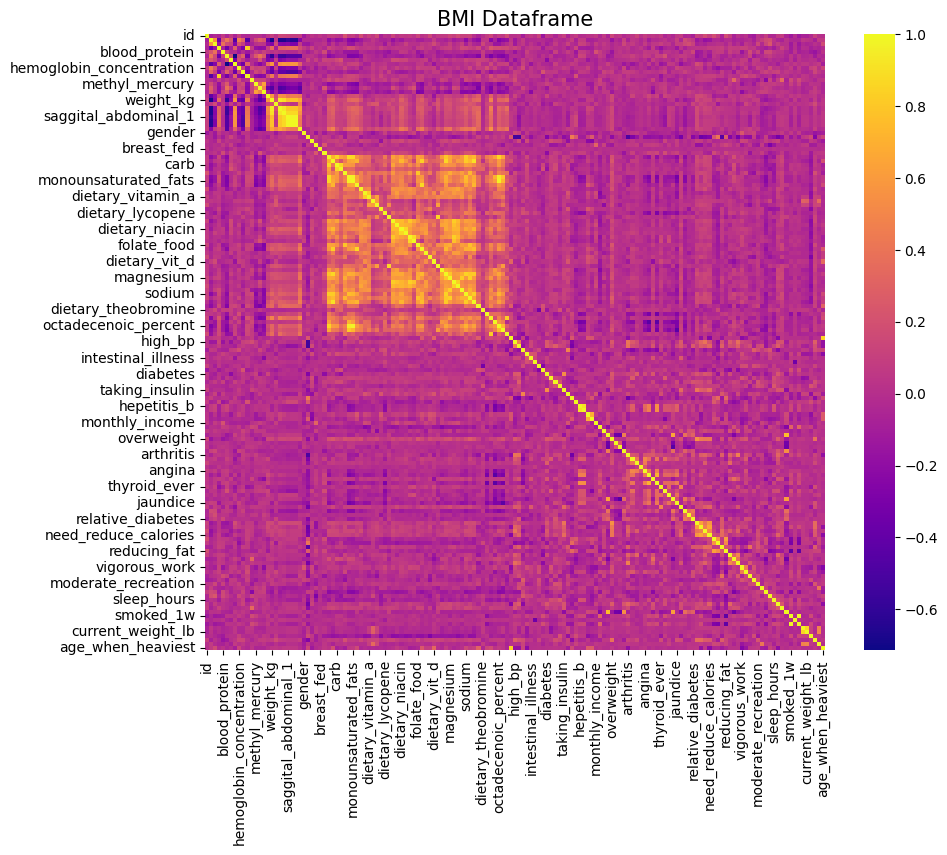

In [14]:
corr_matrix(bmi_df, 'BMI Dataframe')

**Dimensionality Reduction by PCA Discovery**

*Why?* The cleaned dataset has many columns or dimensions or input features. The rows of data therefore only represent a small and non-representative sample. We want to try to reduce the number of dimensions while keeping as much variation in the original dataset as possible. This aid in producing good clustering. 

In [15]:
dfx = fit_and_scale(df)
dfx

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
0,-1.330204,-0.788344,0.144069,14.320731,-1.600895,0.940309,0.267117,-1.246569,-0.429519,0.975432,...,0.009650,-2.519282,0.049326,-2.452094,-0.076513,-0.058998,1.607103,0.492283,0.007413,-0.053101
1,-1.329898,1.329422,-0.857726,3.783136,1.839654,-0.566889,1.444456,2.033758,-1.372313,-0.139365,...,0.059272,-2.519282,0.049326,-2.452094,-0.073974,-0.030405,1.607103,0.492283,-0.016153,-0.059619
2,-1.329592,-2.200187,-1.859520,2.650737,-3.188840,-1.922357,1.226430,0.515088,0.513276,0.603833,...,-0.039971,0.386768,0.049326,0.407815,-0.075244,-0.037553,-0.295559,0.492283,-0.042076,-0.057857
3,-1.329285,0.270539,-0.189863,-0.211714,-0.012949,-0.334235,-0.474171,0.332848,0.199011,0.678153,...,0.009650,0.386768,0.049326,0.407815,-0.080321,-0.087591,-0.295559,0.492283,-0.098635,-0.056976
4,-1.328979,-0.082422,1.813726,0.165752,-0.012949,-1.254738,-0.168935,0.272101,-0.848538,2.461826,...,-0.039971,0.386768,0.049326,0.407815,-0.079052,-0.144778,-2.198222,0.492283,-0.110418,-0.053454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,-1.330204,0.270539,-0.189863,-0.211714,-0.012949,-0.415158,-0.474171,-0.153126,-0.010499,-0.288004,...,-0.039971,0.386768,0.049326,0.407815,-0.075244,-0.069006,1.607103,0.492283,-0.086852,-0.054334
9884,-1.330204,0.270539,-0.189863,-0.211714,-0.012949,-0.415158,-0.474171,-0.153126,-0.010499,-0.288004,...,-0.039971,0.386768,0.049326,0.407815,-0.080321,-0.058998,1.607103,0.492283,-0.098635,-0.056976
9885,-1.330204,0.270539,-0.189863,-0.211714,-0.012949,-0.415158,-0.474171,-0.153126,-0.010499,-0.288004,...,-0.039971,0.386768,0.049326,0.407815,-0.076513,-0.101888,1.607103,0.492283,-0.133984,-0.059442
9886,-1.330204,0.270539,-0.189863,-0.211714,-0.012949,-0.415158,-0.474171,-0.153126,-0.010499,-0.288004,...,-0.039971,0.386768,0.049326,0.407815,-0.082860,-0.037553,-0.295559,-1.899704,-0.080960,-0.056624


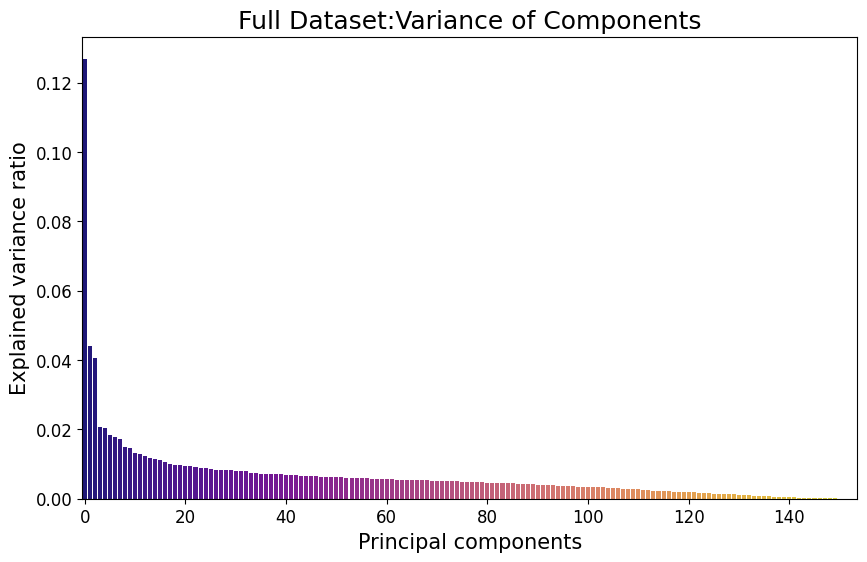

In [16]:
expl_var_bargraph(dfx, None, 'Full Dataset')

Big variance drop at n=1. For clustering, we will go with 2 principal components

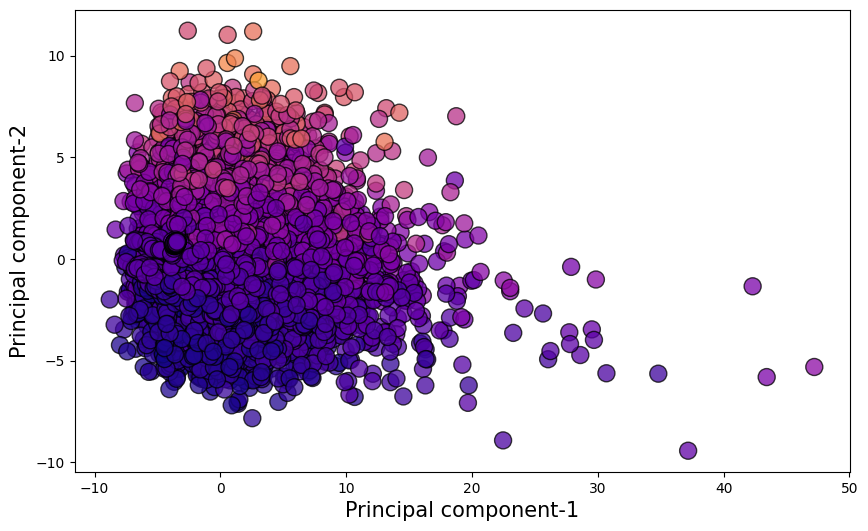

In [17]:
pca_scatter(dfx, None, df.BMI)

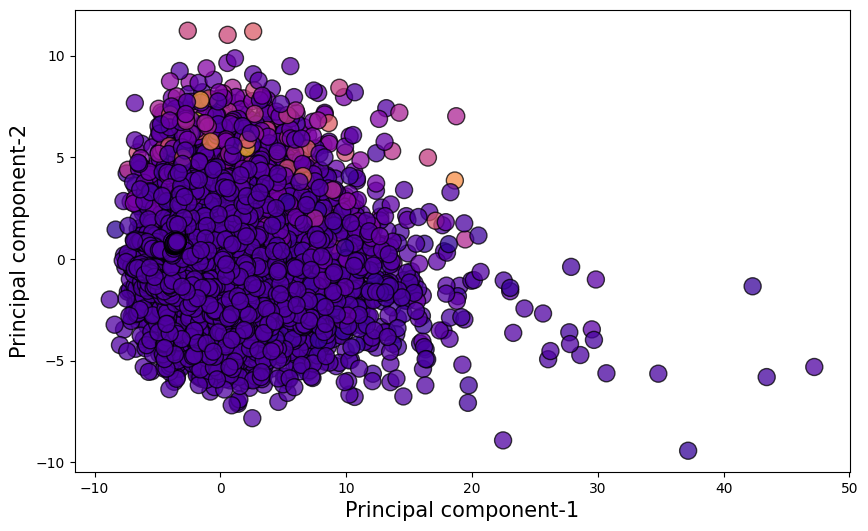

In [18]:
pca_scatter(dfx, None, df.glyco_hemoglobin)

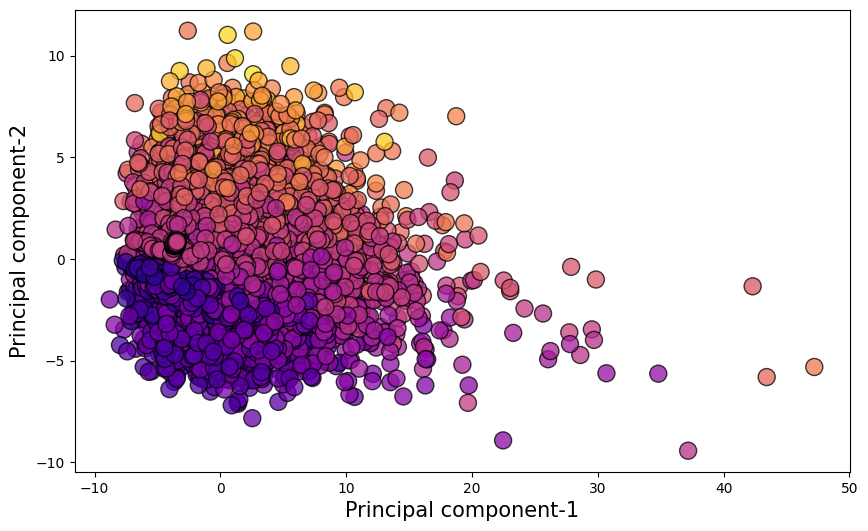

In [19]:
pca_scatter(dfx, None, df.arm_circum)

We can kind of see some separation here

**Clustering by KMeans**

1. Find optimal number of clusters using elbow method
2. Perform clustering with optimal number of clusters.
3. Visualize the clusters by principal components. 

In [20]:
pca = PCA(n_components=2)
pca.fit(dfx)

PCA(n_components=2)

In [21]:
X_pca = pca.transform(dfx)
X_pca

array([[-1.63044487,  4.04177446],
       [19.46217156,  0.96180984],
       [ 0.23075021,  4.03219532],
       ...,
       [-3.50361132,  0.7851461 ],
       [-3.5161262 ,  0.77812298],
       [-3.44443465,  0.85050205]])

In [22]:
X= X_pca
inertia=[]
for n in range (1,11):
    model=KMeans( n_clusters=n, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=111,algorithm='lloyd')
    model.fit(X)
    inertia.append(model.inertia_)
print(inertia)

[260226.78702344775, 142390.09714923418, 106200.70471783246, 81110.97003172043, 66209.51073528273, 55475.83150706441, 49176.66019588297, 43455.264211687696, 38030.85065731681, 34586.620430902105]


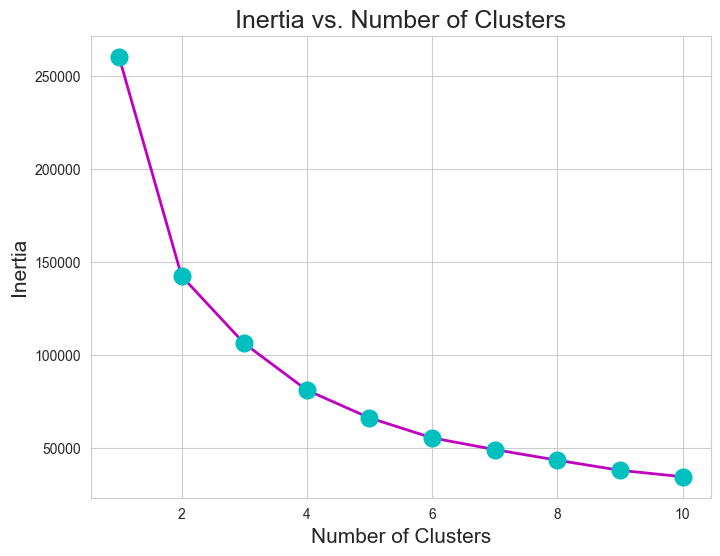

In [23]:
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
plt.plot(list(range(1,11)), inertia, linewidth=2, markersize=12, color='m', marker='o',markerfacecolor='c', markeredgecolor='c')
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Inertia',fontsize=15)
plt.title('Inertia vs. Number of Clusters',fontsize=18)
plt.show()

Based on the elbow method: We can see that if the number of clusters is smaller than 4, the inertia has a high value but if the number of clusters is larger than 4, the inertia is relatively constant. So we chose 4 as the optimal number of clusters

In [24]:
model=KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=111,algorithm='elkan')
model.fit(X)
labels=model.labels_
centers=model.cluster_centers_

In [25]:
centers

array([[-0.38347088,  3.29782235],
       [ 9.94915019, -0.14431921],
       [ 2.36271646, -1.16584524],
       [-3.31297509, -1.00405372]])

Text(0.5, 1.0, 'Clustering of Principal Components')

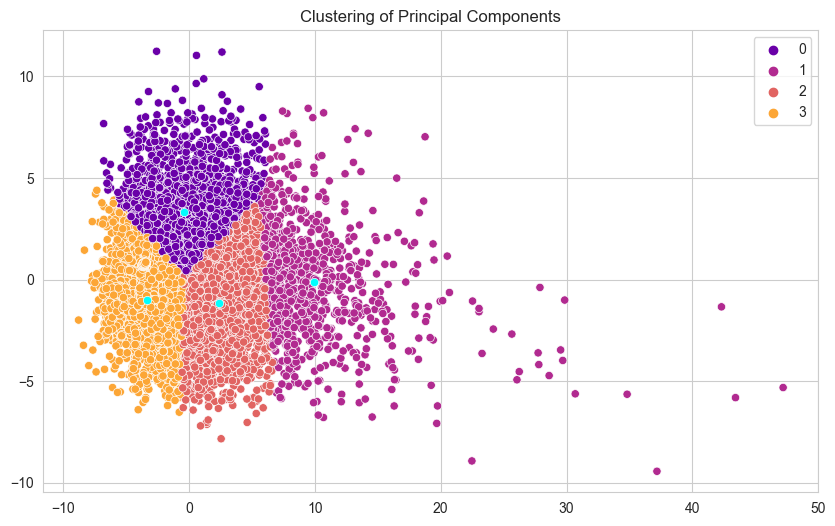

In [26]:
plt.figure(figsize=(10,6))
pal = sns.color_palette("plasma", 4)
sns.scatterplot(data=df,x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=pal)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1],c='cyan', legend=False)
plt.title('Clustering of Principal Components')

The X and Y axes are the 1st and 2nd Principal Components. We can see clearly the segmentation of seperate clusters based on the Principal Components we found earlier.

**Add PCA and K-means to the original Dataframe**

In [27]:
df.head()

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
0,73557.0,4.1,9.5,554.0,6.5,42.2,3.4,2.0,33.4,65.0,...,1.0,1.0,2.0,1.0,69.0,180.0,3.0,2.0,270.0,62.0
1,73558.0,4.7,9.2,219.0,7.8,27.3,6.1,7.4,32.5,50.0,...,2.0,1.0,2.0,1.0,71.0,200.0,3.0,2.0,250.0,25.0
2,73559.0,3.7,8.9,183.0,5.9,13.9,5.6,4.9,34.3,60.0,...,0.0,2.0,2.0,2.0,70.0,195.0,2.0,2.0,228.0,35.0
3,73560.0,4.4,9.4,92.0,7.1,29.6,1.7,4.6,34.0,61.0,...,1.0,2.0,2.0,2.0,66.0,160.0,2.0,2.0,180.0,40.0
4,73561.0,4.3,10.0,104.0,7.1,20.5,2.4,4.5,33.0,85.0,...,0.0,2.0,2.0,2.0,67.0,120.0,1.0,2.0,170.0,60.0


In [28]:
df.reset_index(inplace=True, drop=True)
df_add = pd.DataFrame(data=X_pca, columns=['principal_comp_1', 'principal_comp_2'])
df_add.shape

(9888, 2)

In [29]:
df_new = pd.concat([df, df_add], axis=1)

In [30]:
df_new['cluster_label'] = labels
df_new['cluster_label']=df_new['cluster_label'].apply(lambda x:'first' if x==0  else 'second' if x==1 else 'third' if x==2 else 'fourth')
df_new

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest,principal_comp_1,principal_comp_2,cluster_label
0,73557.0,4.1,9.5,554.0,6.5,42.2,3.4,2.0,33.4,65.0,...,1.0,69.0,180.0,3.0,2.0,270.0,62.0,-1.630445,4.041774,first
1,73558.0,4.7,9.2,219.0,7.8,27.3,6.1,7.4,32.5,50.0,...,1.0,71.0,200.0,3.0,2.0,250.0,25.0,19.462172,0.961810,second
2,73559.0,3.7,8.9,183.0,5.9,13.9,5.6,4.9,34.3,60.0,...,2.0,70.0,195.0,2.0,2.0,228.0,35.0,0.230750,4.032195,first
3,73560.0,4.4,9.4,92.0,7.1,29.6,1.7,4.6,34.0,61.0,...,2.0,66.0,160.0,2.0,2.0,180.0,40.0,-1.306396,-4.004392,fourth
4,73561.0,4.3,10.0,104.0,7.1,20.5,2.4,4.5,33.0,85.0,...,2.0,67.0,120.0,1.0,2.0,170.0,60.0,0.929717,-1.449024,third
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,70.0,173.0,3.0,2.0,190.0,55.0,-3.635481,0.793457,fourth
9884,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,66.0,180.0,3.0,2.0,180.0,40.0,-3.513699,0.759608,fourth
9885,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,69.0,150.0,3.0,2.0,150.0,26.0,-3.503611,0.785146,fourth
9886,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,64.0,195.0,2.0,1.0,195.0,42.0,-3.516126,0.778123,fourth


In [31]:
df_new

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest,principal_comp_1,principal_comp_2,cluster_label
0,73557.0,4.1,9.5,554.0,6.5,42.2,3.4,2.0,33.4,65.0,...,1.0,69.0,180.0,3.0,2.0,270.0,62.0,-1.630445,4.041774,first
1,73558.0,4.7,9.2,219.0,7.8,27.3,6.1,7.4,32.5,50.0,...,1.0,71.0,200.0,3.0,2.0,250.0,25.0,19.462172,0.961810,second
2,73559.0,3.7,8.9,183.0,5.9,13.9,5.6,4.9,34.3,60.0,...,2.0,70.0,195.0,2.0,2.0,228.0,35.0,0.230750,4.032195,first
3,73560.0,4.4,9.4,92.0,7.1,29.6,1.7,4.6,34.0,61.0,...,2.0,66.0,160.0,2.0,2.0,180.0,40.0,-1.306396,-4.004392,fourth
4,73561.0,4.3,10.0,104.0,7.1,20.5,2.4,4.5,33.0,85.0,...,2.0,67.0,120.0,1.0,2.0,170.0,60.0,0.929717,-1.449024,third
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,70.0,173.0,3.0,2.0,190.0,55.0,-3.635481,0.793457,fourth
9884,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,66.0,180.0,3.0,2.0,180.0,40.0,-3.513699,0.759608,fourth
9885,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,69.0,150.0,3.0,2.0,150.0,26.0,-3.503611,0.785146,fourth
9886,73557.0,4.4,9.4,92.0,7.1,28.8,1.7,3.8,33.8,48.0,...,2.0,64.0,195.0,2.0,1.0,195.0,42.0,-3.516126,0.778123,fourth


**What we did:**

1. Reduced the dimensionality by PCA, found we only needed 2 components to represent the most variance in the data, and clusterd the data to four groups that represent (???? what does it represent?)

### **Prediction**

In [32]:
df2 = df.loc[:, ['id', 'gender', 'family_income','glyco_hemoglobin', 'arm_circum', 
                'saggital_abdominal_avg', 'grip_strength', 'breast_fed']]
df2.describe()

,id,gender,family_income,glyco_hemoglobin,arm_circum,saggital_abdominal_avg,grip_strength,breast_fed
count,9888.000000,9888.000000,9888.000000,9888.000000,9888.000000,9888.000000,9888.000000,9888.000000
mean,77900.273159,1.509810,2.474959,5.560164,28.915554,21.625546,60.200040,1.999595
std,3265.282807,0.499929,1.733921,0.828002,7.711130,4.285986,22.581628,0.020110
min,73557.000000,1.000000,0.000000,3.500000,10.400000,10.100000,8.000000,1.000000
25%,74773.750000,1.000000,0.940000,5.300000,23.800000,18.700000,50.300000,2.000000
50%,77776.500000,2.000000,1.975000,5.400000,30.200000,22.900000,52.200000,2.000000
75%,80774.250000,2.000000,4.350000,5.600000,33.700000,22.900000,72.900000,2.000000
max,83730.000000,2.000000,5.000000,17.500000,59.400000,40.100000,162.800000,2.000000


In [33]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(df2)

array([[7.3557e+04, 1.0000e+00, 8.4000e-01, ..., 3.5300e+01, 2.0600e+01,
        5.5200e+01],
       [7.3558e+04, 1.0000e+00, 1.7800e+00, ..., 3.4700e+01, 2.4400e+01,
        6.1500e+01],
       [7.3559e+04, 1.0000e+00, 4.5100e+00, ..., 3.3500e+01, 2.5600e+01,
        9.1000e+01],
       ...,
       [7.3557e+04, 1.0000e+00, 5.0000e+00, ..., 3.3000e+01, 2.2900e+01,
        5.0300e+01],
       [7.3557e+04, 2.0000e+00, 3.6600e+00, ..., 3.3000e+01, 2.2900e+01,
        5.0300e+01],
       [7.3557e+04, 1.0000e+00, 5.0000e+00, ..., 3.3000e+01, 2.2900e+01,
        5.0300e+01]])

In [34]:
# Using GlycoHemoglobin we can create a Diabetes column that determines if someone is diabetec = 2, 
# pre-diabetic = 1, or not diabetic = 0
df2.loc[df2['glyco_hemoglobin'] < 6.0, 'diabetes'] = 0
df2.loc[(df2['glyco_hemoglobin'] >= 6.0) & (df2['glyco_hemoglobin'] <= 6.4), 'diabetes'] = 1
df2.loc[df2['glyco_hemoglobin'] >= 6.5, 'diabetes'] = 2

df2.head(10)

,id,gender,family_income,glyco_hemoglobin,arm_circum,saggital_abdominal_avg,grip_strength,breast_fed,diabetes
0,73557.0,1,0.84,13.9,35.3,20.6,55.2,2.0,2.0
1,73558.0,1,1.78,9.1,34.7,24.4,61.5,2.0,2.0
2,73559.0,1,4.51,8.9,33.5,25.6,91.0,2.0,2.0
3,73560.0,1,2.52,5.4,21.0,14.9,32.2,2.0,0.0
4,73561.0,2,5.00,4.9,25.2,22.9,30.9,2.0,0.0
5,73562.0,1,4.79,5.5,41.8,29.1,53.1,2.0,0.0
6,73564.0,2,5.00,5.5,38.0,26.7,45.9,2.0,0.0
7,73566.0,1,5.00,5.4,29.0,19.9,38.8,2.0,0.0
8,73567.0,2,0.48,5.2,27.5,20.0,43.5,2.0,0.0
9,73568.0,1,1.20,5.2,25.8,14.5,61.0,2.0,0.0


<AxesSubplot: >

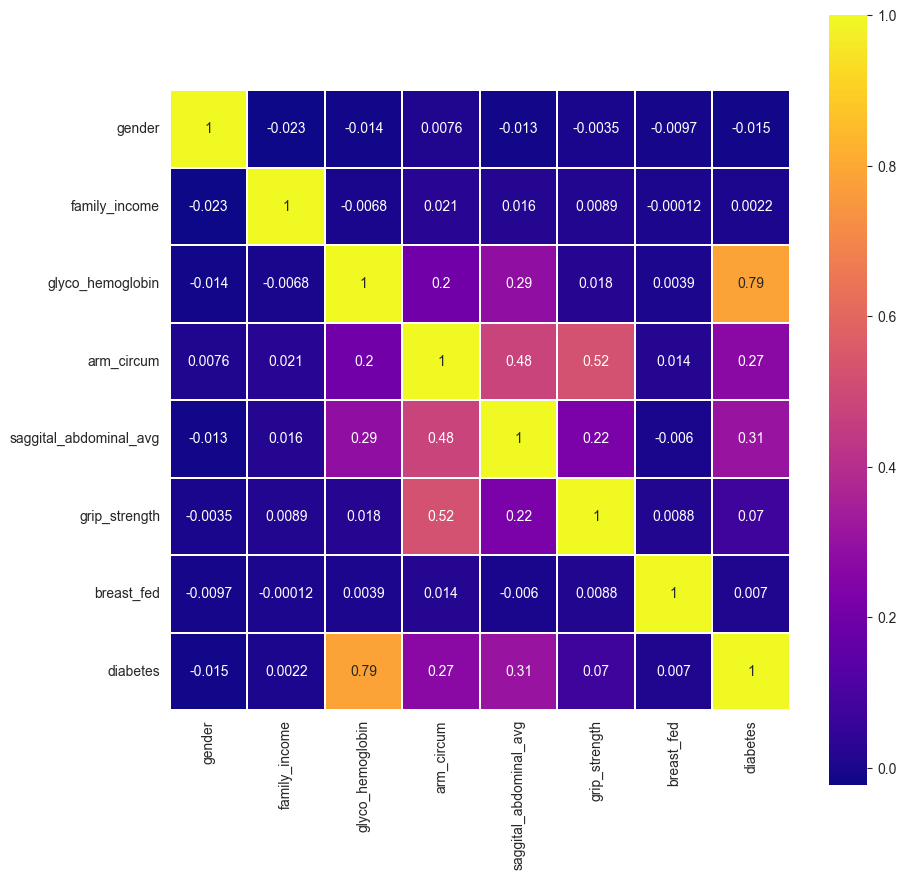

In [35]:
cmap = plt.cm.plasma
plt.figure(figsize=(10,10))
plt.title('Diabetes Target Features Heatmap')
sns.heatmap(df2.astype(float).drop(axis=1, labels='id').corr(), linewidths=0.1, vmax=1.0, square=True, cmap=cmap, annot=True)
# plot a heatmap should show that glycohemoglobin is a good sign of determining diabetes 

In [38]:
# drop glycohemoglobin from dataset
df.drop(['glyco_hemoglobin'], axis = 1, inplace=True)

df.head(5)

,id,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,...,smokers_in_house,smoked_1w,nicotine_1w,tobaco_1w,height_in,current_weight_lb,weightloss_desire,weightloss_attempt,greatest_weight,age_when_heaviest
0,73557.0,4.1,9.5,554.0,6.5,42.2,3.4,2.0,33.4,65.0,...,1.0,1.0,2.0,1.0,69.0,180.0,3.0,2.0,270.0,62.0
1,73558.0,4.7,9.2,219.0,7.8,27.3,6.1,7.4,32.5,50.0,...,2.0,1.0,2.0,1.0,71.0,200.0,3.0,2.0,250.0,25.0
2,73559.0,3.7,8.9,183.0,5.9,13.9,5.6,4.9,34.3,60.0,...,0.0,2.0,2.0,2.0,70.0,195.0,2.0,2.0,228.0,35.0
3,73560.0,4.4,9.4,92.0,7.1,29.6,1.7,4.6,34.0,61.0,...,1.0,2.0,2.0,2.0,66.0,160.0,2.0,2.0,180.0,40.0
4,73561.0,4.3,10.0,104.0,7.1,20.5,2.4,4.5,33.0,85.0,...,0.0,2.0,2.0,2.0,67.0,120.0,1.0,2.0,170.0,60.0


In [40]:
# import linear model from sklearn this will be our first prediction method 
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score

# Our first prediction test will use linear regression 
# Set target set to diabetes column and data to every other column 
# data = attributes, target = diabetes
data = df2.drop(['diabetes'], axis=1)
target = df2[['diabetes']]

# Create 4 data sets to train and test data for predictions 
# Seperate training set and test set
# X holds columns every column except for diabetes 
train_X = data[:6000]
test_X = data[6000:]

# Y holds diabetic or not
train_Y = target[:6000]
test_Y = target[6000:]

#create linear regression obj
lr_regr = linear_model.LinearRegression()

# the .fit() helps learn from the data 
# training via linear regression model
lr_regr.fit(train_X, train_Y)

# make prediction using the test set
lr_pred_diabetes = lr_regr.predict(test_X)
lr_score = lr_regr.score(test_X, test_Y)

# Print results 
print('LRr_Coefficients: ', lr_regr.coef_)
print('LR_Mean Square Error: %.2f' % mean_squared_error(test_Y, lr_pred_diabetes))
print('LR_Variance score: %.2f' % r2_score(test_Y, lr_pred_diabetes))

# Score == prediction accuracy 
print('Score: %.2f' % lr_regr.score(test_X, test_Y))

LRr_Coefficients:  [[-1.93486620e-06 -3.65669285e-03  1.34893278e-05  4.57242822e-01
   7.74355037e-03  7.71748784e-03 -6.67557742e-04  1.72037624e-01]]
LR_Mean Square Error: 0.07
LR_Variance score: 0.61
Score: 0.61


In [41]:
# Our next prediction test will use AdaBoost 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

#create adaboost classification obj
ab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, 
                            learning_rate=0.5, random_state=100)

#training via adaboost classficiation model
ab_clf.fit(train_X, train_Y)
print("training....\n")

#make prediction using the test set
ab_pred_diabetes = ab_clf.predict(test_X)
print('prediction: \n', ab_pred_diabetes)

print('\nparms: \n', ab_clf.get_params)

# Score = prediction accuracy 
ab_clf_score = ab_clf.score(test_X, test_Y)
print("Prediction Accuracy for AdaBoost: %.2f" % ab_clf.score(test_X, test_Y))

training....

prediction: 
 [0. 0. 0. ... 0. 0. 0.]

parms: 
 <bound method BaseEstimator.get_params of AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.5,
                   n_estimators=100, random_state=100)>
Prediction Accuracy for AdaBoost: 1.00


In [42]:
# Next prediction tests 
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False)

# Train via bagging model 
bagging.fit(train_X, train_Y)

# predict using test_X
bg_pred_diabetes = bagging.predict(test_X)

# Score = Accuracy 
bg_dt_score = bagging.score(test_X, test_Y)
print("Prediction Accuracy for baggingClassifier = ", bagging.score(test_X, test_Y))

Prediction Accuracy for baggingClassifier =  0.926440329218107


In [43]:
# Next prediction for BaggingsKNeighbors
bagging = BaggingClassifier(base_estimator= KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False)

# Train data 
bagging.fit(train_X, train_Y)

# Predict 
bg_pred_diabetes = bagging.predict(test_X)

# Accuracy 
bg_score = bagging.score(test_X, test_Y)
print("Prediction Accuracy for KNeighbor = ",bagging.score(test_X, test_Y))

Prediction Accuracy for KNeighbor =  0.9166666666666666


In [44]:
# Last prediction test case 
from sklearn.neural_network import MLPClassifier

# create MLP model 
mlp = MLPClassifier(hidden_layer_sizes=(1000, 300, 300), solver='adam', shuffle=False, tol = 0.0001)

# Train data 
mlp.fit(train_X, train_Y)

# Make prediction 
mlp_pred_diabetes = mlp.predict(test_X)

# Print params
print("parameter: ", mlp.get_params())

# Accuracy 
mlp_score = mlp.score(test_X, test_Y)
print("MLP Accuracy = ",mlp.score(test_X, test_Y))

parameter:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000, 300, 300), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
MLP Accuracy =  0.914866255144033


In [45]:
# Make a dataset with all test cases and their respective accuracy scores 
d = {'Model': ['Linear Regression', 'Adaboost', 'Bagging_decision tree based', 'Bagging_KNeighbors', 'MLP'],
     'accuracy' : [lr_score, ab_clf_score, bg_dt_score, bg_score, mlp_score]}

result_df = pd.DataFrame(data = d)
result_df

,Model,accuracy
0,Linear Regression,0.608382
1,Adaboost,1.000000
2,Bagging_decision tree based,0.926440
3,Bagging_KNeighbors,0.916667
4,MLP,0.914866


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

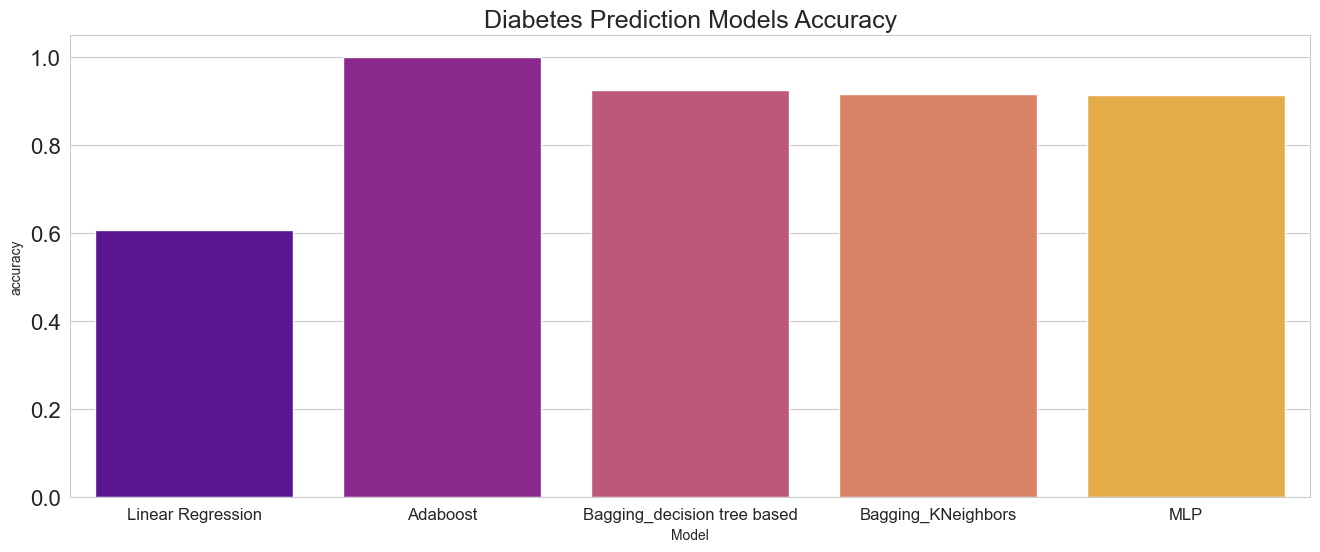

In [55]:
# result_df.bar_lot(x='Model', y='accuracy', kind='bar', figsize=(8, 8), c=cmap=cmap, title='Diabetes Prediction Accuracy', 
#                sort_columns=True)
plt.figure(figsize=(16,6))
sns.barplot(data=result_df, x='Model',y='accuracy', palette='plasma')
plt.title("Diabetes Prediction Models Accuracy", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

Based on the data and observations, we can conclude that all of our test cases, except for LinearRegression, achieved an accuracy rate above 80% in predicting diabetes within this dataset. Therefore, we can confidently assert that the prediction methods offered by sklearn are reliable. 